In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Налаштування
sns.set_style("whitegrid")

# Завантажуємо моделі
print("Завантаження моделей...")
sarima_model = joblib.load('../models/sarima_baseline_model.pkl')
xgb_model = joblib.load('../models/xgboost_tuned_model.pkl')
lstm_model = tf.keras.models.load_model('../models/lstm_model.keras')
scaler = joblib.load('../models/standard_scaler.pkl')
print("Моделі успішно завантажено.")

# Завантажуємо дані для тестів
df_daily = pd.read_csv('../data/dataset_for_modeling.csv', index_col='DateTime', parse_dates=True).resample('D').sum()
df_hourly = pd.read_csv('../data/dataset_for_modeling.csv', index_col='DateTime', parse_dates=True)

Завантаження моделей...
Моделі успішно завантажено.


In [2]:
# --- ОНОВЛЕНА ВЕРСІЯ КОМІРКИ 2 ---

# Дані для SARIMA
n_periods = 1

# Дані для XGBoost
xgb_feature_names = ['day_of_week', 'month', 'day_of_year']
xgb_input = pd.DataFrame(index=df_daily.index[-1:])
xgb_input['day_of_week'] = xgb_input.index.dayofweek
xgb_input['month'] = xgb_input.index.month
xgb_input['day_of_year'] = xgb_input.index.dayofyear
xgb_input = xgb_input[xgb_feature_names]

# --- ЗМІНИ ТУТ ---

# Дані для LSTM (послідовність з 24 годин)
lstm_input_raw = df_hourly.iloc[-24:]
scaler_feature_names = scaler.get_feature_names_out()
lstm_input_subset = lstm_input_raw[scaler_feature_names]
lstm_input_scaled_df = pd.DataFrame(scaler.transform(lstm_input_subset), columns=scaler_feature_names)

# 1. Видаляємо цільову колонку, щоб кількість фіч збігалася з тією, на якій вчилась модель
lstm_input_features = lstm_input_scaled_df.drop(columns=['Global_active_power'])

# 2. Перетворюємо в numpy-масив і додаємо вимір для batch_size
lstm_input = np.expand_dims(lstm_input_features.values, axis=0)


print("Форма вхідних даних для XGBoost:", xgb_input.shape)
print("Форма вхідних даних для LSTM (після виправлення):", lstm_input.shape)
print("\nКолонки, використані для LSTM:", lstm_input_features.columns.to_list())

Форма вхідних даних для XGBoost: (1, 3)
Форма вхідних даних для LSTM (після виправлення): (1, 24, 7)

Колонки, використані для LSTM: ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'is_anomaly']


/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━

,Latency (ms)
SARIMA,1.638098
XGBoost,0.449910
LSTM,28.699689


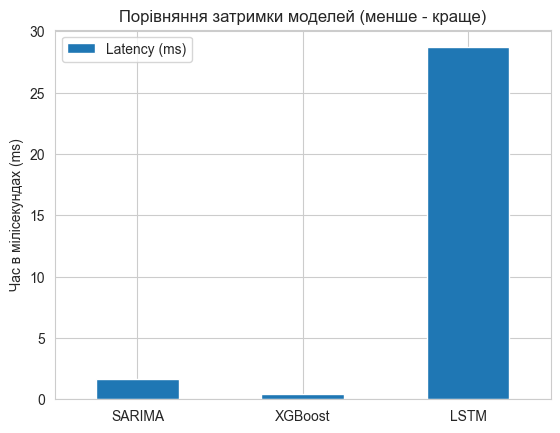

In [3]:
iterations = 100
latency_results = {}

# --- SARIMA ---
start_time = time.time()
for _ in range(iterations):
    sarima_model.predict(n_periods=n_periods)
end_time = time.time()
latency_results['SARIMA'] = (end_time - start_time) / iterations * 1000 # в мілісекундах

# --- XGBoost ---
start_time = time.time()
for _ in range(iterations):
    xgb_model.predict(xgb_input)
end_time = time.time()
latency_results['XGBoost'] = (end_time - start_time) / iterations * 1000

# --- LSTM ---
start_time = time.time()
for _ in range(iterations):
    lstm_model.predict(lstm_input)
end_time = time.time()
latency_results['LSTM'] = (end_time - start_time) / iterations * 1000

# Вивід результатів
latency_df = pd.DataFrame.from_dict(latency_results, orient='index', columns=['Latency (ms)'])
print("Середня затримка для одного прогнозу:")
display(latency_df)

latency_df.plot(kind='bar', title='Порівняння затримки моделей (менше - краще)')
plt.ylabel('Час в мілісекундах (ms)')
plt.xticks(rotation=0)
plt.show()

In [4]:
%load_ext memory_profiler

# --- XGBoost ---
print("Оцінка пам'яті для XGBoost:")
%memit xgb_model = joblib.load('../models/xgboost_tuned_model.pkl')
%memit xgb_model.predict(xgb_input)

print("\n" + "="*30 + "\n")

# --- LSTM ---
print("Оцінка пам'яті для LSTM:")
%memit lstm_model = tf.keras.models.load_model('../models/lstm_model.keras')
%memit lstm_model.predict(lstm_input)

Оцінка пам'яті для XGBoost:
peak memory: 763.23 MiB, increment: 0.00 MiB
peak memory: 763.14 MiB, increment: 0.00 MiB


Оцінка пам'яті для LSTM:
peak memory: 763.17 MiB, increment: 0.03 MiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
peak memory: 764.05 MiB, increment: 0.88 MiB


Starting scalability test...
Batch size: 1, Time: 0.0014 seconds
Batch size: 10, Time: 0.0009 seconds
Batch size: 50, Time: 0.0006 seconds
Batch size: 100, Time: 0.0007 seconds
Batch size: 200, Time: 0.0008 seconds
Batch size: 330, Time: 0.0007 seconds


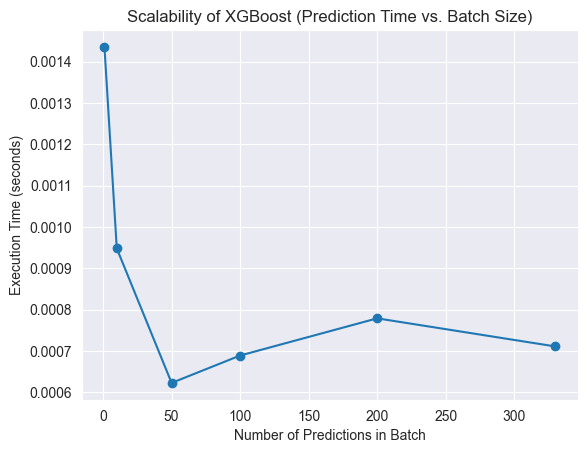

In [6]:
# --- UPDATED VERSION OF CELL 6 ---

batch_sizes = [1, 10, 50, 100, 200, 330]
scalability_results = []

# --- CORRECTION STARTS HERE ---
# 1. Define the list of columns the model expects
xgb_feature_names = ['day_of_week', 'month', 'day_of_year']

# 2. Prepare the full feature set for the test period
X_daily_features_full = df_daily.loc['2010-01-01':].copy()
X_daily_features_full['day_of_week'] = X_daily_features_full.index.dayofweek
X_daily_features_full['month'] = X_daily_features_full.index.month
X_daily_features_full['day_of_year'] = X_daily_features_full.index.dayofyear

# 3. Select ONLY the required columns
X_daily_test_final = X_daily_features_full[xgb_feature_names]

# -------------------------------

print("Starting scalability test...")
for size in batch_sizes:
    # We take a slice from the correctly prepared dataframe
    batch_input = X_daily_test_final.iloc[:size]

    start_time = time.time()
    xgb_model.predict(batch_input)
    end_time = time.time()

    scalability_results.append(end_time - start_time)
    print(f"Batch size: {size}, Time: {end_time - start_time:.4f} seconds")

# Visualization
plt.plot(batch_sizes, scalability_results, marker='o')
plt.title('Scalability of XGBoost (Prediction Time vs. Batch Size)')
plt.xlabel('Number of Predictions in Batch')
plt.ylabel('Execution Time (seconds)')
plt.show()